In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [10]:
import pandas as pd

import pyspark

from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline



from pyspark.ml.feature import StringIndexer, VectorIndexer, StringIndexerModel, IndexToString
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [16]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
data = spark.read.csv('diabetic_data.csv', header=True, inferSchema=True)
train, test = data.randomSplit([0.8, 0.2], seed=42)
# Writing the data to csv
train.write.csv("train.csv", header=True, mode="overwrite")
test.write.csv("test.csv", header=True, mode="overwrite")
# Indexing the columns
labelIndexer = StringIndexer(inputCol="readmitted", outputCol="label")

indexedrace = StringIndexer(inputCol="race", outputCol="indexedrace",handleInvalid="keep")
indexedgender = StringIndexer(inputCol="gender", outputCol="indexedgender",handleInvalid="keep")
indexedage = StringIndexer(inputCol="age", outputCol="indexedage",handleInvalid="keep")
indexedmax_glu_serum = StringIndexer(inputCol="max_glu_serum", outputCol="indexedmax_glu_serum",handleInvalid="keep")

# Assembling features
assembler = VectorAssembler(
    inputCols=["indexedrace", "indexedgender", "indexedage", "indexedmax_glu_serum"],
    outputCol="features"
)

# Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier(labelCol="label", featuresCol="features")


In [17]:
indexedLabelTrain=labelIndexer.fit(train).transform(train)
indexedLabelTrain.show(5)

+------------+-----------+---------------+------+--------+------+-----------------+------------------------+-------------------+----------------+----------+-----------------+------------------+--------------+---------------+-----------------+----------------+----------------+------+------+------+----------------+-------------+---------+---------+-----------+-----------+--------------+-----------+-------------+---------+---------+-----------+------------+-------------+--------+--------+------------+----------+-------+-----------+-------+-------------------+-------------------+------------------------+-----------------------+----------------------+------+-----------+----------+-----+
|encounter_id|patient_nbr|           race|gender|     age|weight|admission_type_id|discharge_disposition_id|admission_source_id|time_in_hospital|payer_code|medical_specialty|num_lab_procedures|num_procedures|num_medications|number_outpatient|number_emergency|number_inpatient|diag_1|diag_2|diag_3|number_diagn

In [18]:

# Creating the pipeline
pipeline = Pipeline(stages=[
    labelIndexer, 
    indexedrace, 
    indexedgender, 
    indexedage,
    indexedmax_glu_serum,
    assembler, 
    decision_tree_classifier
])

In [19]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# ParamGrid for Cross Validation
paramGrid = ParamGridBuilder() \
    .addGrid(decision_tree_classifier.maxDepth, [5, 10, 15]) \
    .addGrid(decision_tree_classifier.maxBins, [32, 64, 128]) \
    .build()

# Evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [20]:
cvModel = crossval.fit(train)


In [21]:

# Transform the test data using the fitted model
testSolutions = cvModel.transform(test).select('patient_nbr', 'prediction')

# Converting the predictions back to original labels
# Taking the labels from StringIndexerModel
labelIndexerModel = labelIndexer.fit(train)
labelsArray = labelIndexerModel.labels
testSolutions = IndexToString(inputCol="prediction", outputCol="acceptability", labels=labelsArray).transform(testSolutions)
testSolutions.show()

# Selecting and saving the final solutions
solutions = testSolutions
solutions.show()


+-----------+----------+-------------+
|patient_nbr|prediction|acceptability|
+-----------+----------+-------------+
|   42519267|       0.0|           NO|
|   85504905|       0.0|           NO|
|   84259809|       0.0|           NO|
|   92519352|       0.0|           NO|
|   21239181|       0.0|           NO|
|   21861756|       0.0|           NO|
|   96664626|       0.0|           NO|
|  112002975|       0.0|           NO|
|   51838164|       0.0|           NO|
|   82442376|       0.0|           NO|
|   90097839|       0.0|           NO|
|   21820806|       0.0|           NO|
|   37746639|       0.0|           NO|
|   93232917|       0.0|           NO|
|   24370299|       0.0|           NO|
|   95075649|       0.0|           NO|
|   34806888|       0.0|           NO|
|   91530936|       0.0|           NO|
|   49407813|       0.0|           NO|
|     720936|       0.0|           NO|
+-----------+----------+-------------+
only showing top 20 rows

+-----------+----------+-------------+

Test Comparison:
   patient_nbr  prediction acceptability readmitted
0     42519267         0.0            NO         NO
1     85504905         0.0            NO        <30
2     84259809         0.0            NO         NO
3     92519352         0.0            NO        <30
4     21239181         0.0            NO         NO


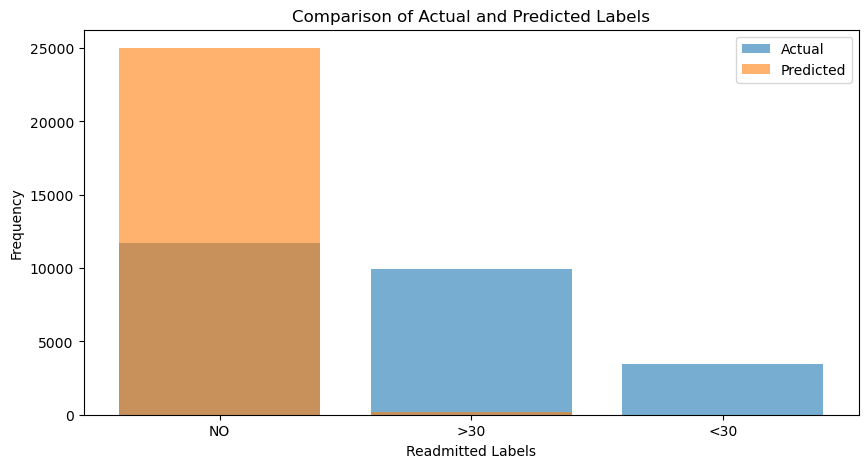

In [24]:
# Convert the test and train datasets to pandas dataframes for comparison
test_pd = test.select('patient_nbr', 'readmitted').toPandas()
train_pd = train.select('patient_nbr', 'readmitted').toPandas()

# Merge the solutions with the test and train dataframes
test_comparison = testSolutions.toPandas().merge(test_pd, on='patient_nbr', how='left')
train_comparison = testSolutions.toPandas().merge(train_pd, on='patient_nbr', how='left')

# Display the comparison results
print("Test Comparison:")
print(test_comparison.head())
import matplotlib.pyplot as plt

# Plot the comparison of actual and predicted labels
plt.figure(figsize=(10, 5))
actual_counts = test_comparison['readmitted'].value_counts()
predicted_counts = test_comparison['acceptability'].value_counts()

plt.bar(actual_counts.index, actual_counts.values, alpha=0.6, label='Actual')
plt.bar(predicted_counts.index, predicted_counts.values, alpha=0.6, label='Predicted')
plt.title('Comparison of Actual and Predicted Labels')
plt.xlabel('Readmitted Labels')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()
